In [1]:
import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm_notebook
import numpy as np

from criterion import RPNLoss, FRCNNLoss
from datasets import PascalVOC

from models import FasterRCNN, Base_CNN, RegionProposalNetwork, ROIPooling, Classifier
from utils import plot_with_bbs2


## setup data

In [2]:
path = '/home/austin/data/VOC/VOC2007/'
tr_mean, tr_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
trans = transforms.Compose([transforms.Scale(600),
                            transforms.ToTensor(),
                            transforms.Normalize(tr_mean, tr_std)])
voc = PascalVOC(root=path + 'JPEGImages', annFile=path + "pascal_train2007.json", transform=trans)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [3]:
base_cnn = Base_CNN()
rpn = RegionProposalNetwork()
roi_pool = ROIPooling()
classifier = Classifier()

In [4]:
frcnn = FasterRCNN(base_cnn, rpn, roi_pool, classifier)
frcnn.cuda()

FasterRCNN (
  (base_cnn): Base_CNN (
    (vggfeats): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (9): ReLU (inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (12): ReLU (inplace)
      (13): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): BatchNorm2d(256, eps=1e-05,

In [5]:
loader = DataLoader(voc)
filtered_paramters = filter(lambda p: p.requires_grad, frcnn.parameters())
optimizer = Adam(filtered_paramters, lr=1e-3)

rpn_criterion = RPNLoss()
classifier_criterion = FRCNNLoss()

In [6]:
img, target = next(iter(loader))


In [7]:
frcnn.train()

FasterRCNN (
  (base_cnn): Base_CNN (
    (vggfeats): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (9): ReLU (inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (12): ReLU (inplace)
      (13): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): BatchNorm2d(256, eps=1e-05,

In [8]:
pbar = tqdm_notebook(loader, total=len(loader))
for img, target in pbar:
    frcnn.train()
    img = Variable(img).cuda()
    rpn_cls_scores, rpn_bbox_deltas, out_class, out_bbox_deltas, skip = frcnn(img, target)
    if skip:
        continue
    labels, bbox_targets = frcnn.get_rpn_targets()
    classifier_labels, classifier_bbox_targets = frcnn.get_classifier_targets()
    rpn_loss = rpn_criterion(rpn_cls_scores,
                             rpn_bbox_deltas,
                             Variable(labels).cuda(),
                             Variable(bbox_targets).cuda())
    
    cls_loss = classifier_criterion(out_class,
                                    out_bbox_deltas,
                                    Variable(classifier_labels).cuda(),
                                    Variable(classifier_bbox_targets).cuda())
    pbar.set_description(desc='rpn loss {:.4f} | cls loss {:.4f}'.format(rpn_loss.data[0],
                                                                 cls_loss.data[0]))
    loss = rpn_loss + cls_loss
    loss.backward()
    optimizer.step()
    break

Widget Javascript not detected.  It may not be installed or enabled properly.


In [9]:
def save_checkpoint(model_state, optimizer_state, filename, epoch=None, is_best=False):
    state = dict(model_state=model_state,
                 optimizer_state=optimizer_state,
                 epoch=epoch)
    torch.save(state, filename)
    if is_best:
        copyfile(filename, 'model_best.pth.tar')

In [10]:
# save_checkpoint(frcnn.state_dict(), optimizer.state_dict(), 'frcnn2epoch.pt')

In [11]:
rpn_cls_scores, rpn_bbox_deltas, out_class, out_regr, skip = frcnn(img, target)

In [12]:
pred_labs = np.argmax(out_class.data.cpu().numpy(), axis=1)


In [13]:
def bbox_reg(boxes, box_deltas, im):
    boxes = boxes[:,1:]
    box_deltas = box_deltas.data.numpy()
    pred_boxes = bbox_transform_inv(boxes, box_deltas)
    pred_boxes = clip_boxes(pred_boxes, im.size()[-2:])
    return pred_boxes

In [14]:
bboxes = frcnn.get_roi_boxes

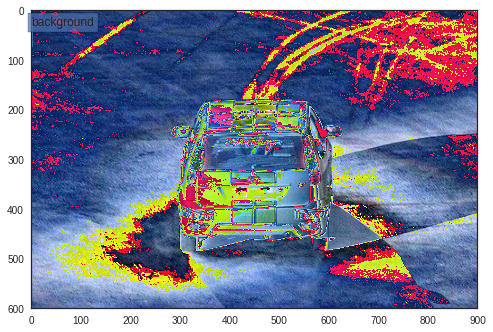

In [15]:
plot_with_bbs2(img.squeeze(0).data.cpu(), out_regr.data.cpu().numpy().reshape(-1, 21, 4)[range(len(pred_labs)), pred_labs, :] * 16, pred_labs, voc.classes)

In [16]:
img.squeeze(0)

Variable containing:
( 0 ,.,.) = 
 -0.9363 -0.9534 -0.9877  ...  -1.1932 -1.2274 -1.2445
 -0.9192 -0.9363 -0.9705  ...  -1.2103 -1.2274 -1.2274
 -0.8849 -0.9020 -0.9363  ...  -1.2617 -1.2274 -1.2103
           ...             ⋱             ...          
 -0.7479 -0.7479 -0.7308  ...  -0.7650 -0.7650 -0.7650
 -0.7308 -0.7308 -0.7137  ...  -0.7650 -0.7650 -0.7650
 -0.7137 -0.7137 -0.6965  ...  -0.7650 -0.7650 -0.7650

( 1 ,.,.) = 
 -0.8277 -0.8452 -0.8803  ...  -1.0553 -1.0903 -1.1078
 -0.8102 -0.8277 -0.8627  ...  -1.0728 -1.0903 -1.0903
 -0.7752 -0.7927 -0.8277  ...  -1.1253 -1.0903 -1.0728
           ...             ⋱             ...          
 -0.6527 -0.6527 -0.6352  ...  -0.6527 -0.6527 -0.6527
 -0.6352 -0.6352 -0.6176  ...  -0.6527 -0.6527 -0.6527
 -0.6176 -0.6176 -0.6001  ...  -0.6527 -0.6527 -0.6527

( 2 ,.,.) = 
 -0.6367 -0.6541 -0.6890  ...  -0.8458 -0.8807 -0.8981
 -0.6193 -0.6367 -0.6715  ...  -0.8633 -0.8807 -0.8807
 -0.5844 -0.6018 -0.6367  ...  -0.9156 -0.8807 -0.8633
   

In [17]:
out_class, out_regr.data.cpu()

(Variable containing:
 
 Columns 0 to 7 
  19.4563  -5.0744  -2.9665  -4.5962  -4.4230  -2.0091  -1.7337   9.8678
 
 Columns 8 to 15 
  -3.9116  -6.5664  -4.4392  -4.1416  -5.5268  -1.0429  -3.8576  -2.5810
 
 Columns 16 to 20 
  -4.3920  -2.3438  -6.5879  -3.8779  -5.6483
 [torch.cuda.FloatTensor of size 1x21 (GPU 0)], 
 
 Columns 0 to 9 
 -0.0947  1.3034 -1.1247  2.9946  3.5624  0.5979  2.7274  0.8401 -0.4779  0.9575
 
 Columns 10 to 19 
 -2.8577  1.1997  1.4005  0.5677 -2.7528  1.1778  3.0688 -1.3225 -0.1351 -0.9029
 
 Columns 20 to 29 
  0.6588  3.0741 -1.2173  1.7504  0.4311  0.1651  2.0233 -0.5960  1.2138  0.7142
 
 Columns 30 to 39 
  0.7591  2.0479  1.6411 -0.4832 -2.2873 -1.4430 -2.3284 -3.8750  1.4140  3.7624
 
 Columns 40 to 49 
 -2.0013 -1.4640  4.2132  3.9207  4.5867 -4.0183  3.0233  1.0785 -3.0757  1.1358
 
 Columns 50 to 59 
 -2.5068 -1.7596  1.2238  1.8502  0.5639 -0.3674 -1.3258 -3.1802  0.9952  2.6306
 
 Columns 60 to 69 
 -3.2977  1.1037  0.0609  0.0301 -2.8641 -3.37